In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import datetime
import geocoder
import os
from IPython.display import Image
import geopandas as gpd
from glob import *
import numpy as np
import pylab as pl
%pylab inline
%matplotlib inline
ox.config(log_console=True, use_cache=True)

Populating the interactive namespace from numpy and matplotlib


### Most Critical Node

In [4]:
def get_bc_graph_plots(place):
    
    string = place.split(',')[0]
    
    G = nx.read_gpickle("data/{a}/{b}".format(a=string, b=string))
    b = ox.basic_stats(G)
    
    #G_projected = ox.project_graph(G)
    node_lis = glob('data/{}/nodes/nodes.shp'.format(string))
    extended_path_lis = glob('data/{}/Extended_*.csv'.format(string))
    
    gdf_node = gpd.GeoDataFrame.from_file(node_lis[0])
    exten = pd.read_csv(extended_path_lis[0])
    exten= exten.rename(columns={'Unnamed: 0':'osmid'})
    exten['betweenness_centrality'] = exten['betweenness_centrality']*100
    
    max_node = exten[exten.betweenness_centrality == max(exten.betweenness_centrality)]['osmid'].values[0]
    max_bc = max(exten.betweenness_centrality)
    
    nc = ['r' if node==max_node else '#336699' for node in G.nodes()]
    ns = [80 if node==max_node else 8 for node in G.nodes()]
    
    print('{}: The most critical node has {:.2f}% of shortest journeys passing through it. \n'.format(place, max_bc))
    print('The road network of {} has {} nodes and {} edges \n\n'.format(string, b['n'], b['m']))
    fig, ax =  ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, node_alpha=0.8, edge_alpha=0.8,
                            fig_height=8,fig_width=8)
    gdf_node[gdf_node.osmid ==  max_node].plot(ax=ax, color='red', zorder = 3)
    
    #ax.set_title('{}: {:.2f}% of shortest paths between all nodes \n in the network through this node'.format(string, max_bc), fontsize=15)
    
    

    print('\n\n\n')
    
    fig.savefig('data/{}/{}_bc_graph_plot.png'.format(string, string), dpi=300)

Addis Ababa: The most critical node has 13.93% of shortest journeys passing through it. 

The road network of Addis Ababa has 57230 nodes and 154538 edges 




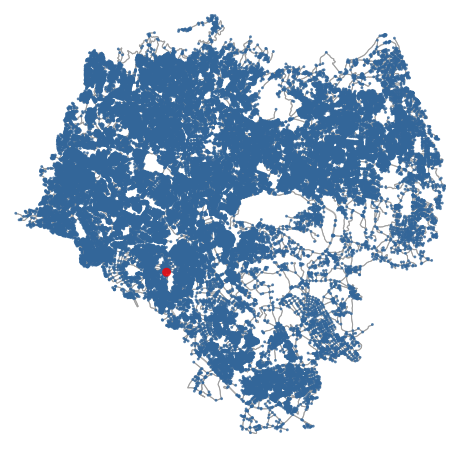

/home/wb542830/.conda/envs/osmnx/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


In [5]:
get_bc_graph_plots('Addis Ababa')

In [33]:
def get_netowrk_plots(city):
    string = city.split(',')[0]
    
    G = get_graph(string)
    
    fig, ax = ox.plot_graph(G, node_color = '#336699', node_zorder = 2 )
    
    fig.savefig('data/{}/{}_network_plot.png'.format(string, string), dpi=300)

Fetching graph data for Addis Ababa


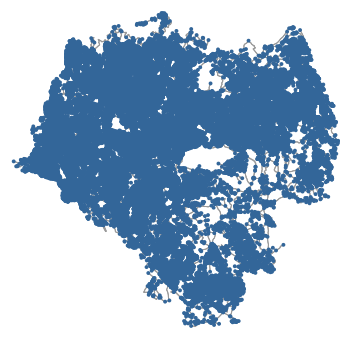

In [34]:
get_netowrk_plots('Addis Ababa')

### Sqaure Mile Plot

In [17]:
img_folder = 'images'
extension = 'png'

In [6]:
def make_plot(place, point, network_type='drive', bldg_color='orange', dpi=300,
              dist=1200, default_width=4, street_widths=None):
    gdf = ox.footprints.footprints_from_point(point=point, distance=dist)
    fig, ax = ox.plot_figure_ground(point=point, dist=dist, network_type=network_type, default_width=default_width,
                                    street_widths=street_widths, save=False, show=False, close=True)
    fig, ax = ox.footprints.plot_footprints(gdf, fig=fig, ax=ax, color=bldg_color, set_bounds=False,
                                save=True, show=False, close=True, filename=place, dpi=dpi)

In [20]:
## Trinity Cathedral 
place = 'Addis Ababa'
point = (9.030620, 38.766884)
make_plot(place, point)
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)

OSError: [Errno 5] Input/output error

### Radar Plot

In [2]:
def get_polygon(string):
    
    lis = glob('data/AOI/*/*.shp')
    
    city = []
    for i in lis:
        x = i.split('/')[-2]
        city.append(x.split('_')[0])
        
    if string in city:
        l = glob('data/AOI/{a}/*.shp'.format(a=string))
        adm = gpd.GeoDataFrame.from_file(l[0])
        boundary_poly = adm.geometry.values[0]
    else:
        boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=1)
        boundary_poly = boundary_GDF.loc[0,'geometry']
        if boundary_poly.geom_type == 'Polygon':
            boundary_poly = boundary_poly
        else:
            try:
                boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=2)
                boundary_poly = boundary_GDF.loc[0,'geometry']
            except:
                return -1
    
    return boundary_poly

In [3]:
def get_graph(place):
    string = place.split(',')[0]
    
    print('Fetching graph data for {}'.format(place))
    
    poly = get_polygon(string)
    
    if poly == -1:
        gdf = ox.gdf_from_place('{}'.format(string))
        G = ox.graph_from_bbox(gdf.bbox_north, gdf.bbox_south, gdf.bbox_east, gdf.bbox_west)
    else:
        try:
            G = nx.read_gpickle('data/{a}/{a}'.format(a=string))
        except FileNotFoundError:
            G = ox.graph_from_polygon(poly, network_type='drive')

    G = ox.project_graph(G)
    
    return G

In [20]:
def plot_radar(city):
    string = city.split(',')[0]
    #G = ox.graph_from_place(city, network_type='drive')
    G = get_graph(city)
    G = ox.add_edge_bearings(G)
    bearings = pd.Series([data['bearing'] for u, v, k, data in G.edges(keys=True, data=True)])
    #ax = bearings.hist(bins=30, zorder=2, alpha=0.8)
    #xlim = ax.set_xlim(0, 360)
    #ax.set_title('{} street network compass bearings'.format(city))
    #plt.show()
    fig = plt.figure()
    n = 30
    bearings = bearings[bearings>0]
    count, division = np.histogram(bearings, bins=[ang*360/n for ang in range(0,n+1)])
    division = division[0:-1]
    width =  2 * np.pi/n
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = 'polar')
    ax = plt.subplot(111, projection='polar')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')
    bars = ax.bar(division * np.pi/180 - width * 0.5 , count, width=width, bottom=0.0)
    ax.set_title('{} street network compass bearings'.format(city), y=1.03)
    fig.savefig('data/{a}/{a}_radar_plot.png'.format(a=string), dpi=300)
    
    return(ax)

Fetching graph data for Addis Ababa


/home/wb542830/.conda/envs/osmnx/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

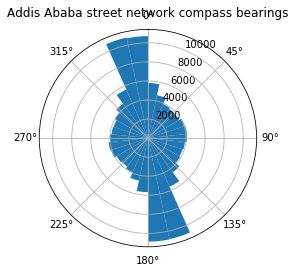

In [21]:
plot_radar('Addis Ababa')